# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.preprocessing import LabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import (
    GaussianNB, 
    MultinomialNB
)
import xgboost as xgb
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold, 
    cross_validate
)
from sklearn.metrics import (
    accuracy_score, 
    mean_squared_error
)
from warnings import filterwarnings


filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Importing Cleaned Data

In [ ]:
imdb_df=pd.read_csv('./clean_imdb.csv')

print(imdb_df.shape)
imdb_df.sample(10)

(49582, 2)


,review,sentiment
19282,film great well written entertaining david duc...,1
22712,movie better expected think deserved r rating ...,1
23489,caught part george tv recently get watch end a...,0
45765,id like say film good touching film explains r...,1
5217,friz freleng speedy gonzalez second cartoon fe...,0
2989,watched movie tcm last night excited expectati...,1
27520,shortage female flesh still interesting lenzi ...,0
16177,think include spoiler cover butt last american...,1
4836,agreeable french movie deal millionaire owner ...,1
22251,another many nearly forgotten movie cranked po...,0


In [ ]:
data, target = imdb_df["review"], imdb_df["sentiment"]

# Data Vectorizing

In [ ]:
%%time

tfidf_vect = TfidfVectorizer(max_features=1000, ngram_range=(1,3)) 
data_tfidf = tfidf_vect.fit_transform(data).toarray()

data_tfidf.shape

CPU times: user 51.2 s, sys: 1.96 s, total: 53.2 s
Wall time: 53.3 s


(49582, 1000)

# Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_tfidf, 
    target, 
    test_size=0.20, 
    random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((39665, 1000), (39665,), (9917, 1000), (9917,))

# Various Models

In [ ]:
%%time

models = [
    DummyClassifier,
    LogisticRegression,
    LinearSVC,
    GaussianNB,
    MultinomialNB,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    xgb.XGBClassifier,
]

for model in models:
  if model == LinearSVC:
    cls = model(penalty='l2', loss='hinge')
  else:
    cls = model()

  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  cv_results = cross_validate(
      cls,
      data_tfidf,
      target,
      cv=cv,
      scoring='accuracy',
      error_score='raise',
      n_jobs = -1
  )
  print(f"{model.__name__:22} AUC: "
        f"{cv_results['test_score'].mean():.3f} STD: {cv_results['test_score'].std():.3f}"
  )

DummyClassifier        AUC: 0.502 STD: 0.000
LogisticRegression     AUC: 0.863 STD: 0.005
LinearSVC              AUC: 0.863 STD: 0.004
GaussianNB             AUC: 0.816 STD: 0.004
MultinomialNB          AUC: 0.837 STD: 0.003
RandomForestClassifier AUC: 0.831 STD: 0.004
GradientBoostingClassifier AUC: 0.809 STD: 0.002
HistGradientBoostingClassifier AUC: 0.845 STD: 0.005
XGBClassifier          AUC: 0.807 STD: 0.003
CPU times: user 30.6 s, sys: 6.1 s, total: 36.8 s
Wall time: 1h 17min 58s


# Model Optimization

In [ ]:
!pip install optuna --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", 
        ["logit", "linsvc", "multinb", "hist", "xgb"])
    
    if classifier_name == "logit":
        logit_penalty = trial.suggest_categorical('logit_penalty', ['l1','l2'])
        logit_c = trial.suggest_float('logit_c', 0.001, 10)
        logit_solver = 'saga'
        
        model = LogisticRegression(
            penalty=logit_penalty,
            C=logit_c,
            solver=logit_solver,
        )

    elif classifier_name == "linsvc":
      svc_penalty = trial.suggest_categorical('svc_penalty', ['l1','l2'])
      svc_loss = trial.suggest_categorical('svc_loss', ['hinge','squared_hinge'])

      model = LinearSVC(
          penalty=svc_penalty,
          loss=svc_loss
      )
    
    elif classifier_name == "multinb":
      alpha = trial.suggest_float('alpha', 1, 10)

      model = MultinomialNB(alpha=alpha)
  
    elif classifier_name == "hist":
        hist_learning_rate = trial.suggest_float("hist_learning_rate", 0.01, 1)
        hist_max_iter = trial.suggest_int("hist_max_iter", 100, 1000)
        hist_max_leaf_nodes = trial.suggest_int("hist_max_leaf_nodes", 10, 150)

        model = HistGradientBoostingClassifier(
            learning_rate=hist_learning_rate,
            max_iter=hist_max_iter,
            max_leaf_nodes=hist_max_leaf_nodes
        )
    
    elif classifier_name == "xgb":
        xgb_eta = trial.suggest_float("xgb_eta", 0.01, 1)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 1, 15)
        xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 1, 15)
        model = xgb.XGBClassifier(
            eta=xgb_eta,
            max_depth=xgb_max_depth,
            min_child_weight=xgb_min_child_weight,
        )

    kf= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    score = cross_val_score(
        model,
        data_tfidf,
        target,
        cv=kf,
        scoring="accuracy",
        n_jobs=-1
    )

    acc = score.mean()

    return acc

In [ ]:
%%time

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.CmaEsSampler()
)

study.optimize(objective, n_trials=10)

print("Cma-Es Sample")
print(f"ES best params: {study.best_params}")
print(f"ES best score: {study.best_value}")
print()
result = study.trials_dataframe()
print(result["params_classifier"].value_counts())
res = result.groupby(["params_classifier"])["value"].agg(["mean", "std"])
print(res)

[I 2023-01-18 16:20:14,024] A new study created in memory with name: no-name-af55f0c2-26b1-43f2-9fb9-0a34619494f1
[I 2023-01-18 16:20:16,038] Trial 0 finished with value: 0.8364123902452476 and parameters: {'classifier': 'multinb', 'alpha': 4.629094201591809}. Best is trial 0 with value: 0.8364123902452476.
[I 2023-01-18 16:20:16,041] `CmaEsSampler` only supports two or more dimensional continuous search space. `RandomSampler` is used instead of `CmaEsSampler`.
[I 2023-01-18 16:20:19,849] Trial 1 finished with value: 0.8617844934253214 and parameters: {'classifier': 'linsvc', 'svc_penalty': 'l2', 'svc_loss': 'hinge'}. Best is trial 1 with value: 0.8617844934253214.
[I 2023-01-18 16:20:21,692] Trial 2 finished with value: 0.8364325861081017 and parameters: {'classifier': 'multinb', 'alpha': 9.9732665140822}. Best is trial 1 with value: 0.8617844934253214.
[I 2023-01-18 16:20:25,529] Trial 3 finished with value: 0.8618248302378072 and parameters: {'classifier': 'linsvc', 'svc_penalty': '

Cma-Es Sample
ES best params: {'classifier': 'linsvc', 'svc_penalty': 'l2', 'svc_loss': 'squared_hinge'}
ES best score: 0.8624097496107567

linsvc     5
xgb        3
multinb    2
Name: params_classifier, dtype: int64
                       mean       std
params_classifier                    
linsvc             0.862168  0.000332
multinb            0.836422  0.000014
xgb                0.820405  0.026117
CPU times: user 17.8 s, sys: 4.63 s, total: 22.4 s
Wall time: 43min


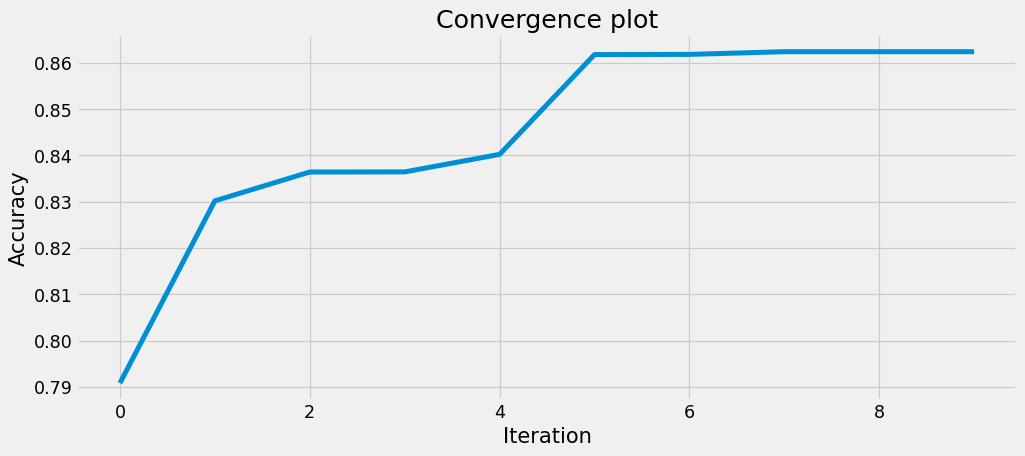

In [ ]:
fig = plt.figure(figsize=(12, 5), dpi=90)
result['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
fig.savefig('linear_svc_acc.png',bbox_inches='tight')

# Fitting the model

In [ ]:
# {'classifier': 'linsvc', 'svc_penalty': 'l2', 'svc_loss': 'squared_hinge'}
model = LinearSVC(
          penalty='l2',
          loss='squared_hinge'
      )

model.fit(X_train, y_train)

LinearSVC()

# Evaluate Model

In [ ]:
y_preds = model.predict(X_test)
acc = accuracy_score(y_test, y_preds)
rmse = mean_squared_error(y_test, y_preds)
print(f"Accuracy : {100*acc: .3f}")
print(f"RMSE : {rmse: .3f}")

Accuracy :  86.064
RMSE :  0.139


# CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [ ]:
X_train

array([[0.        , 0.        , 0.1956833 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05125188, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0809842 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1501642 , 0.        , 0.        , ..., 0.        , 0.10018625,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
model = Sequential()

model.add(Dense(16, activation='relu', input_shape=(1000,)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                16016     
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=['accuracy','mean_squared_error']
)

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=256, 
    validation_data=(X_test, y_test), 
    epochs=5,
    verbose=1
)

Epoch 1/5
155/155 [==============================] - 1s 5ms/step - loss: 0.1755 - accuracy: 0.9149 - mean_squared_error: 0.0547 - val_loss: 0.4692 - val_accuracy: 0.8474 - val_mean_squared_error: 0.1174
Epoch 2/5
155/155 [==============================] - 1s 4ms/step - loss: 0.1719 - accuracy: 0.9180 - mean_squared_error: 0.0537 - val_loss: 0.4709 - val_accuracy: 0.8444 - val_mean_squared_error: 0.1178
Epoch 3/5
155/155 [==============================] - 1s 5ms/step - loss: 0.1683 - accuracy: 0.9186 - mean_squared_error: 0.0527 - val_loss: 0.4848 - val_accuracy: 0.8455 - val_mean_squared_error: 0.1186
Epoch 4/5
155/155 [==============================] - 1s 4ms/step - loss: 0.1643 - accuracy: 0.9205 - mean_squared_error: 0.0514 - val_loss: 0.4860 - val_accuracy: 0.8431 - val_mean_squared_error: 0.1194
Epoch 5/5
155/155 [==============================] - 1s 4ms/step - loss: 0.1615 - accuracy: 0.9218 - mean_squared_error: 0.0505 - val_loss: 0.5088 - val_accuracy: 0.8436 - val_mean_squared

In [ ]:
df_model = pd.DataFrame(history.history)
df_model.head()

,loss,accuracy,mean_squared_error,val_loss,val_accuracy,val_mean_squared_error
0,0.175485,0.914912,0.054725,0.469236,0.847434,0.117373
1,0.171936,0.917988,0.053694,0.470931,0.844409,0.117844
2,0.168330,0.918593,0.052679,0.484773,0.845518,0.118562
3,0.164328,0.920484,0.051422,0.485961,0.843098,0.119366
4,0.161496,0.921770,0.050482,0.508835,0.843602,0.120337


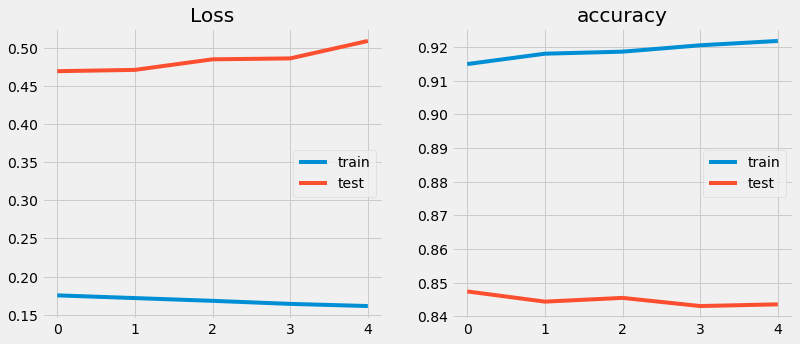

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model)), df_model.loss, label="train")
plt.plot(range(len(df_model)), df_model.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model)), df_model.accuracy, label="train")
plt.plot(range(len(df_model)), df_model.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

# LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, 
    Dropout, 
    Bidirectional, 
    Dense, 
    Embedding
)


X = data
y = target.values

MAX_FEATURES = 200000
MAX_SEQ = 1800

vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=MAX_SEQ,
    output_mode='int'
)

vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

dataset = (
    tf.data.Dataset.from_tensor_slices((vectorized_text, y))
    .cache()
    .shuffle(160000)
    .batch(16)
    .prefetch(8)
)

train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=['accuracy','mean_squared_error']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                        

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=256, 
    validation_data=(X_test, y_test), 
    epochs=100,
    verbose=1
)

Epoch 1/100
155/155 [==============================] - 13s 80ms/step - loss: 0.6932 - accuracy: 0.5018 - mean_squared_error: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.5021 - val_mean_squared_error: 0.2500
Epoch 2/100
155/155 [==============================] - 12s 80ms/step - loss: 0.6932 - accuracy: 0.5010 - mean_squared_error: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.5021 - val_mean_squared_error: 0.2500
Epoch 3/100
155/155 [==============================] - 12s 80ms/step - loss: 0.6932 - accuracy: 0.5018 - mean_squared_error: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.5021 - val_mean_squared_error: 0.2500
Epoch 4/100
155/155 [==============================] - 12s 80ms/step - loss: 0.6932 - accuracy: 0.4970 - mean_squared_error: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.5021 - val_mean_squared_error: 0.2500
Epoch 5/100
155/155 [==============================] - 12s 79ms/step - loss: 0.6932 - accuracy: 0.5018 - mean_squared_error: 0.2500 - val_loss: 0.6931 - val_accuracy: 0.502

In [ ]:
df_model = pd.DataFrame(history.history)
df_model.head()

,loss,accuracy,mean_squared_error,val_loss,val_accuracy,val_mean_squared_error
0,0.693158,0.501828,0.250006,0.693139,0.502067,0.249996
1,0.693152,0.500971,0.250002,0.693140,0.502067,0.249996
2,0.693151,0.501828,0.250002,0.693142,0.502067,0.249997
3,0.693164,0.497038,0.250008,0.693139,0.502067,0.249996
4,0.693152,0.501828,0.250003,0.693141,0.502067,0.249997


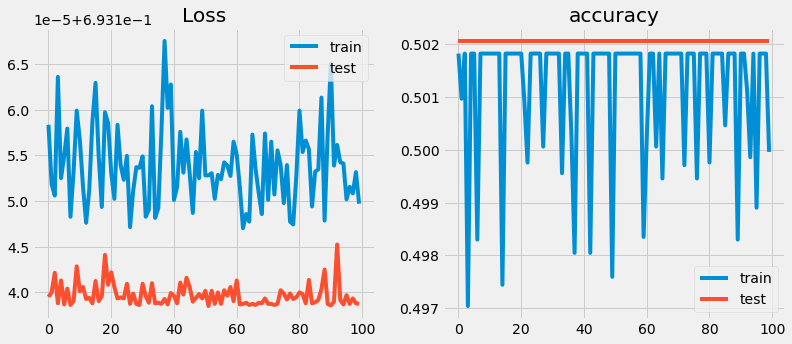

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(df_model)), df_model.loss, label="train")
plt.plot(range(len(df_model)), df_model.val_loss, label="test")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(df_model)), df_model.accuracy, label="train")
plt.plot(range(len(df_model)), df_model.val_accuracy, label="test")
plt.title("accuracy")
plt.legend()
plt.show()

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(imdb_df.columns[1]):
        text += f'{col}: {results[0][idx]>0.5}\n'
    
    return text

In [ ]:
!pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 86.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import gradio as gr

interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1df06019-0455-4552.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
